# LA County Property Valuation and Pricing: Regression Analysis
---

## Contents
* __Overview__
    * Motivation
    * Dataset
    
    
* __Part 1:__ Model Selection
    * Categorical Filters
    *  Feature Selection
    * Outlier Detection


* __Part 2:__ Total Assessed Value - 2015


* __Part 3:__ Growth Adjustment


* __Part 4:__ Sale Price Confidence Interval


* __Automation__


* __After Thoughts__

---

# Overview

One of the most fundamental components of investment analysis is the study of the relationship between value and market price. Put simply, we want to search for opportunities in the market which maximize value for a minimal price. In this workbook, we will value real estate properties using the *comparables* approach and test the valuation against the market price. By specifying a set of characteristics, we will filter through the main dataset to construct a customized training set. From this subset of the main dataset, we will build and optimize valuation models.

The dataset contains characteristic information on real estate properties. It is substantial and contains a wide variety of data points across different categories, so we must filter the data to improve the reliability of our models. Since the main data set is not uniformly distributed across zip codes, the usage of categorical information to filter the data set will depend on available data. (In particular, we will filter to match as many of these categories as possible, while still having sufficient data to model with.)

After filtering our data by category, we will tweak our models by choosing features with highest correlation to assessed value, removing outliers, and subsequently applying a property-tier constraint. (Step 1 below.) After fine-tuning the models based on available and relevant training data, we will apply the linear model to our orignial input and predict the 2015 value of the property (step 2). Using real estate growth data published by Zillow, we will adjust this output to a valuation for 2017 (step 3). Finally, we will apply a conversion factor to convert the assessed value to a predicted market price range based on sales data and statistical metrics (step 4).

To illustrate the reasoning behind our analysis, we will first study selected data points and explain the behavior of our model components. Along this pipeline from input to predicted sale price, we will take note of limiting assumptions and adjust the models accordingly. Finally, we will encapsulate an automated version of the entire process by defining a Valuation class.

$\Large 1. \hspace{0.3cm} input \rightarrow algorithm \rightarrow  "best" \hspace{0.02cm} available \hspace{0.15cm} model$

$\Large 2. \hspace{0.3cm} input \rightarrow "best" \hspace{0.02cm} available \hspace{0.15cm} model \rightarrow 2015 \hspace{0.1cm} valuation$

$\Large 3. \hspace{0.3cm} 2015 \hspace{0.1cm} valuation \times ZHVI growth \hspace{0.1cm} \% = 2017 \hspace{0.1cm} valuation $

$\Large 4. \hspace{0.3cm} 2017 \hspace{0.1cm} valuation \times Sale Price Conversion \% = Predicted \hspace{0.1cm} Sale \hspace{0.1cm} Price$

---

# Part 1: Model Selection

### Columns to be used as categorical filters:

* __zip code__: this is the most location-specific feature of the dataset we will use to model around. this is a required input
* __property land use type ID__: type of land use the property is zoned for (e.g. commercial, residential general, condominium, etc.)
* __heating or system type ID__: type of home heating system
* __unit count__: number of units the structure is built into (e.g. duplex, triplex, etc.) Despite being numerically valued, this is really a description of the type of property and is best left as a category
* __pool count__: values are 1 or 0 (i.e. do or do not contain a pool); this is best left as a category

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

sns.set_style('whitegrid')

%matplotlib inline

In [2]:
properties = pd.read_csv(os.getcwd()+'\data_clean\ca_properties_2016.csv')
properties = properties.set_index('zipcode')

In [56]:
properties

,city,parcelid,propertylandusetypeid,longitude,latitude,bathroomcnt,bedroomcnt,roomcnt,calculatedfinishedsquarefeet,yearbuilt,lotsizesquarefeet,unitcnt,buildingqualitytypeid,heatingorsystemtypeid,poolcnt,totalassessedvalue
zipcode,,,,,,,,,,,,,,,,
91304,Los Angeles,10717217,261,-118.628236,34.217790,2.0,3,0,1766,1962,9085,1,4,2,1,502580
91304,Los Angeles,10718048,261,-118.662872,34.207325,3.0,5,0,3085,1995,34845,1,1,2,0,1427972
91304,Los Angeles,10718101,261,-118.637068,34.218324,3.0,5,0,2401,1965,11009,1,4,2,1,393270
91304,Los Angeles,10718224,261,-118.638939,34.212078,3.0,4,0,2397,1984,12910,1,4,2,1,799956
91304,Los Angeles,10718347,261,-118.643730,34.217005,3.0,4,0,2574,1981,10095,1,4,2,1,761944
91304,Los Angeles,10718693,261,-118.634765,34.218867,3.0,4,0,2225,1965,11119,1,4,2,1,547833
91304,Los Angeles,10718793,261,-118.639462,34.214457,3.0,4,0,2661,1983,9787,1,4,2,1,681112
91307,Los Angeles,10719384,261,-118.623456,34.201279,3.0,4,0,1830,1960,8280,1,7,2,0,559667
91307,Los Angeles,10719753,261,-118.618965,34.206413,2.0,3,0,1358,1956,7551,1,7,2,1,467994


1642900


count      263.000000
mean      6246.768061
std       3752.365190
min         19.000000
25%       3531.000000
50%       5819.000000
75%       8113.000000
max      20953.000000
Name: zipcode, dtype: float64

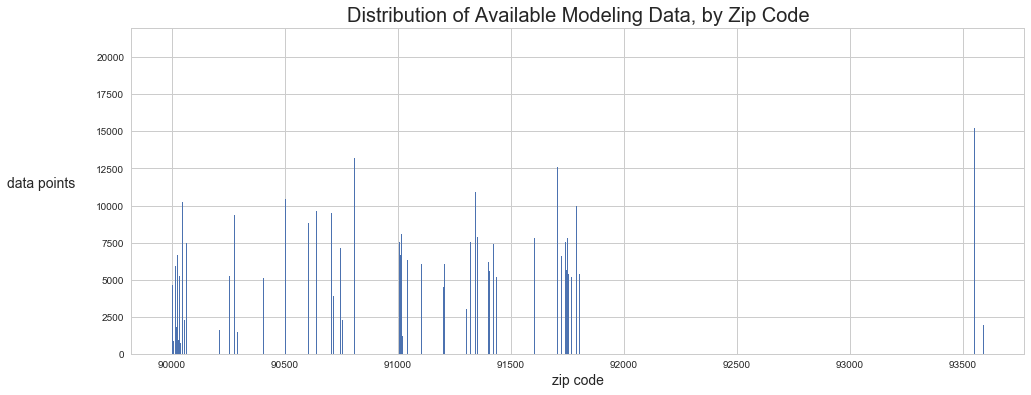

In [3]:
f, (ax1) = plt.subplots(1,1,figsize=(16,6))

ax1.bar(properties.reset_index()['zipcode'].value_counts().index,properties.reset_index()['zipcode'].value_counts())
ax1.set_title('Distribution of Available Modeling Data, by Zip Code',fontsize=20)
ax1.set_xlabel('zip code',fontsize=14)
ax1.set_ylabel('data points',fontsize=14,rotation=0,labelpad=55)

print(len(properties))
properties.reset_index()['zipcode'].value_counts().describe()

Our training set contains over 1.6 million properties with 263 distinct zip codes. Since location is one of the most influential factors in determing the value of a property, zip codes will be a required input feature and will be the first layer with which we filter our dataset for predictive modeling.

Beginning with a zip code, we will cut down our training set size based on categorical filters. This improves the relevance of our training set, but will reduce the number of training examples. 


In [45]:
print('property land use type id: ' + str(len(np.unique(properties['propertylandusetypeid']))))
print('heating or system type id: ' + str(len(np.unique(properties['heatingorsystemtypeid']))))
print('unit count: ' +str(len(np.unique(properties['unitcnt']))))
print('pool count: ' + str(len(np.unique(properties['poolcnt']))))

property land use type id: 10
heating or system type id: 3
unit count: 20
pool count: 2


These columns contain a relatively few number of values--we can treat them as discrete. Despite being numerically valued, the numbers are really only mappings to define categorical information. Thus, these columns will not be included in our regression analysis and chosen as categories to pre-process the modeling dataset. 

The data dictionary can be found at the end of the workbook. 

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
x_unfiltered = properties['calculatedfinishedsquarefeet']
y_unfiltered = properties['totalassessedvalue']
lr1 = LinearRegression()
lr1.fit(x_unfiltered.to_frame(),y_unfiltered.to_frame())
x1 = np.linspace(0,8000,100)
y1 = x1*lr1.coef_[0] + lr1.intercept_


x_filtered = properties.loc[91307]['calculatedfinishedsquarefeet']
y_filtered = properties.loc[91307]['totalassessedvalue']
lr2 = LinearRegression()
lr2.fit(x_filtered.to_frame(),y_filtered.to_frame())
x2 = np.linspace(0,8000,100)
y2 = x2*lr2.coef_[0] + lr2.intercept_

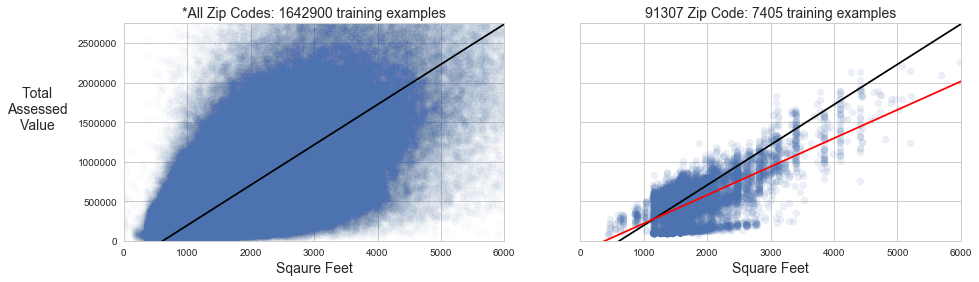

In [50]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4),sharey=True)

ax1.scatter(x_unfiltered,y_unfiltered,alpha=0.02)
ax1.plot(x1,y1,'k')
ax1.set_xlim([0,6000])
ax1.set_ylim([0,2750000])
ax1.set_title('*All Zip Codes: '+ str(len(x_unfiltered))+' training examples',fontsize=14)
ax1.set_ylabel('Total\nAssessed\nValue',rotation=0,labelpad=40,fontsize=14)
ax1.set_xlabel('Sqaure Feet' ,fontsize=14)

ax2.scatter(x_filtered,y_filtered,alpha=0.1)
ax2.plot(x1,y1,'k')
ax2.plot(x2,y2,'r')
ax2.set_xlim([0,6000])
ax2.set_ylim([0,2750000])
ax2.set_title('91307 Zip Code: '+ str(len(x_filtered))+' training examples',fontsize=14)
ax2.set_xlabel('Square Feet',fontsize=14)


As an example, we graphically show above the much higher variance observed in the relationship between square footage of properties and their predicted assessed value, when we do not specify a zip code. A linear assumption almost seems inappropriate in the general case (at the very least, it is unreliable); however in the location-specific plot, linear regression appears to be a reasonable model. 

When we specify a location, our linear model is slightly adjusted (the best-fit line changes from black to red). Furthermore, a visual analysis of the location-specific plot shows a much more clear linear relationship (i.e. it has a better fit). However, the training set size is reduced from 1.6 million to 7405. This is still sufficiently high, but we must take note of this reduction with each categorical filter we apply.

\* *Note that the opacity is set lower for the left-hand graph. This is to better illustrate the change in density around the best-fit line. (There are so many datapoints for the left-hand graph that the density levels are otherwise indiscernable.)*

In [7]:
x_f1 = properties.loc[90024]['calculatedfinishedsquarefeet']
y_f1 = properties.loc[90024]['totalassessedvalue']

lr3 = LinearRegression()
lr3.fit(x_f1.to_frame(),y_f1.to_frame())
x3 = np.linspace(0,4000,2)
y3 = x3*lr3.coef_[0] + lr3.intercept_


x_f2 = properties.loc[90024][properties.loc[90024]['propertylandusetypeid']==266]['calculatedfinishedsquarefeet']
y_f2 = properties.loc[90024][properties.loc[90024]['propertylandusetypeid']==266]['totalassessedvalue']

lr4 = LinearRegression()
lr4.fit(x_f2.to_frame(),y_f2.to_frame())
x4 = np.linspace(0,4000,2)
y4 = x4*lr4.coef_[0] + lr4.intercept_

7405 training examples used in zip code model
4241 training examples used in zip code & property type model


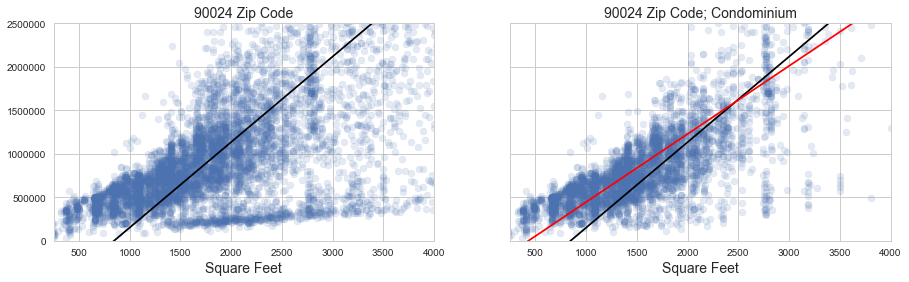

In [8]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4),sharey=True)

ax1.scatter(x_f1,y_f1,alpha=0.15)
ax1.plot(x3,y3,'k')
ax1.set_xlim([250,4000])
ax1.set_ylim([0,2500000])
ax1.set_title('90024 Zip Code',fontsize=14)
ax1.set_xlabel('Square Feet',fontsize=14)

ax2.scatter(x_f2,y_f2,alpha=0.15)
ax2.plot(x3,y3,'k')
ax2.plot(x4,y4,'r')
ax2.set_xlim([250,4000])
ax2.set_ylim([0,2500000])
ax2.set_title('90024 Zip Code; Condominium',fontsize=14)
ax2.set_xlabel('Square Feet',fontsize=14)

print(str(len(x_filtered)) + ' training examples used in zip code model')
print(str(len(x_f2)) + ' training examples used in zip code & property type model')


When we add an additional filtering criteria, our fitted line is again adjusted from the black line to the red line. (In particular, notice that the cluster of data points near the bottom of the left-hand graph disappears from the right-hand graph. It seems that this was a group of properties of a different class which were skewing the valuation model for condominiums.) Since the linear model on the right is built from training examples which have more similar characteristics to our hypothetical input, it is reasonable to assume that it will do a better job in valuing the property.

Note, however, that the number of training examples used in the more specific model has again been cut by a significant factor. It is still sufficiently high, but our final algorithm will need a check to ensure that this number does not fall below a threshold. In that case, the algorithm will predict the value based on a more general model, and will account for this when outputting confidence intervals for the value of the property.

---

### Feature candidates for linear model:

For a given zip code, we will calculate correlations between assessed value and the following variables. The features below will be used if they have a correlation above a threshold absolute value of 0.2.

* __calculated finished square feet__: total finished living area of structure
* __lot size square feet__: area of lot
* __building quality type ID__: overall assessment of building condition (lowest = best; highest = worst). Although this may seem like categorical information, there exists an obvious numerical relationship between the quality of a building and its value. Therefore, we will use this information as a feature. 
* __latitude__: for certain regions, latitude and longitude play a significant role in valuation. (For example, properties higher up in hills tend to be valued higher.)
* __longitude__
* __year built__
* __room count__
* __bathroom count__
* __bedroom count__

In [9]:
features = ['calculatedfinishedsquarefeet','bathroomcnt','bedroomcnt','buildingqualitytypeid','lotsizesquarefeet',
           'latitude','longitude','yearbuilt','roomcnt','totalassessedvalue']

In [10]:
properties[features].corr()['totalassessedvalue'].sort_values(ascending=False)

totalassessedvalue              1.000000
calculatedfinishedsquarefeet    0.647142
bathroomcnt                     0.536924
bedroomcnt                      0.303769
yearbuilt                       0.144349
lotsizesquarefeet               0.003141
roomcnt                         0.001399
latitude                       -0.017477
buildingqualitytypeid          -0.090570
longitude                      -0.169651
Name: totalassessedvalue, dtype: float64

In [11]:
properties[features].loc[91304].corr()['totalassessedvalue'].sort_values(ascending=False)

totalassessedvalue              1.000000
calculatedfinishedsquarefeet    0.756331
bathroomcnt                     0.637797
bedroomcnt                      0.554183
yearbuilt                       0.410167
latitude                       -0.198977
lotsizesquarefeet              -0.233884
buildingqualitytypeid          -0.313282
longitude                      -0.527611
roomcnt                              NaN
Name: totalassessedvalue, dtype: float64

As an example, notice how correlations with assessed value change when we specify location. Not only are many of the correlations more significant, certain variables now play a role in valuation due to location-specific behavior. In particular, notice in the 91304 correlations vector that longitude has a significant correlation with assessed value. In the 91304 region, a more negative longitude (farther eastward) corresponds to a property higher up in the hills. Resultantly, the valuation tends to be higher.

In [12]:
features_to_use = properties[features].loc[91304].corr()['totalassessedvalue'][np.abs(properties[features].loc[91304].corr()['totalassessedvalue'].sort_values(ascending=False)) > 0.2]
features_to_use = features_to_use[features_to_use.index != 'totalassessedvalue']
features_to_use

calculatedfinishedsquarefeet    0.756331
bathroomcnt                     0.637797
bedroomcnt                      0.554183
buildingqualitytypeid          -0.313282
lotsizesquarefeet              -0.233884
longitude                      -0.527611
yearbuilt                       0.410167
Name: totalassessedvalue, dtype: float64

In [53]:
input_Xs = [2782,3.5,6,3,10890,-118.64,1963]

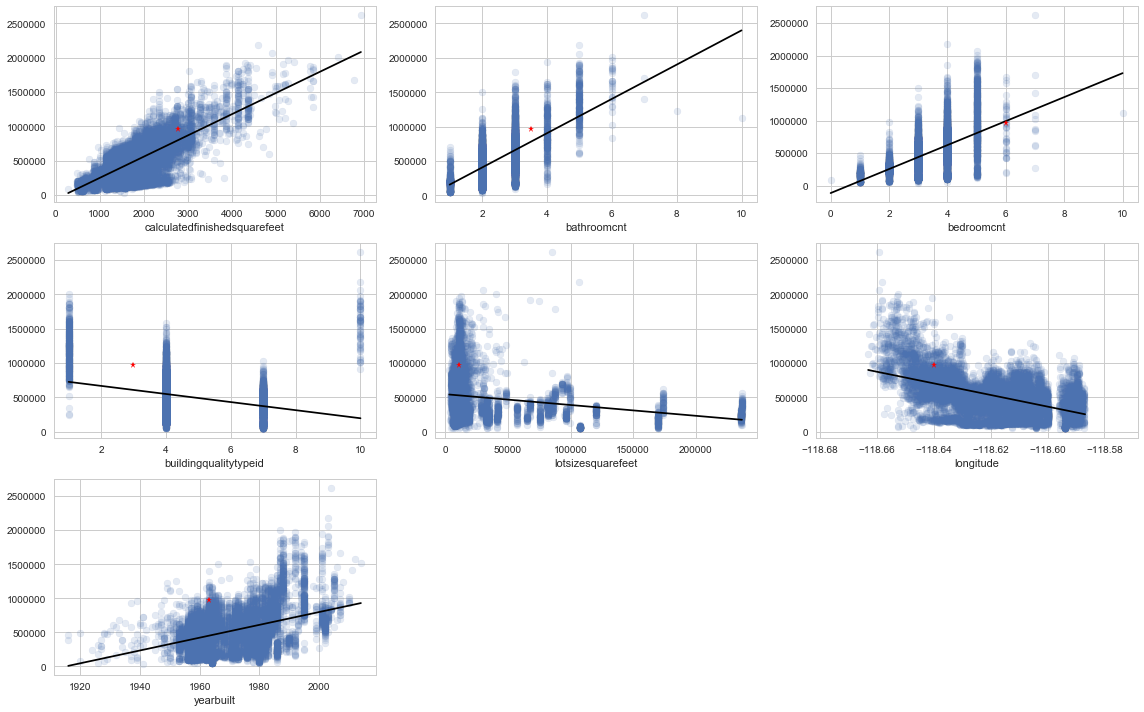

In [54]:
lr = LinearRegression()

fig = plt.figure(figsize=(16,10))

for i in range(len(features_to_use.index)):
    x = properties.loc[91304][features_to_use.index[i]]
    y = properties.loc[91304]['totalassessedvalue']
    lr.fit(x.to_frame(),y.to_frame())
    xl = np.linspace(min(x),max(x),2)
    yl = xl*lr.coef_[0] + lr.intercept_
    
    ax = fig.add_subplot(3,3,i+1)
    ax.scatter(properties.loc[91304][features_to_use.index[i]],properties.loc[91304]['totalassessedvalue'],alpha=0.15)
    ax.plot(xl,yl,'k')
    ax.plot(input_Xs[i],969000,'*r')
    ax.set_xlabel(str(features_to_use.index[i]))
    
plt.tight_layout()

In [55]:
# ADD a predicted value that is growth/sales adjusted for each feature

We can plot the listed price against the predicted value and see how much of a bargain we are getting with respect to each characteristic of the house. For example, this plot shows that the list price of 969000 is fairly high with respect the averages for most of the features it has. However, for a house with 6 bedrooms, it seems the list price is slightly below average.

The variance between actual assessed value and predicted value (the best-fit line in black) is fairly large for each plot, but we can expect this to decrease when we model all the features together.

# Part 2: Total Assessed Value - 2015

In [15]:
lr.fit(properties.loc[91304][features_to_use.index],properties.loc[91304]['totalassessedvalue'])
SD = np.sqrt(lr.residues_/len(properties.loc[91304][features_to_use.index])-1)

ex_input = pd.DataFrame([2782,3.5,6,3,10890,-118.64,1963])
ex_input_listprice = 969000

predicted_value = lr.predict(ex_input[0])[0]

print('standard deviation: ' + str(int(SD)))
print('70% CI: [' + str(predicted_value - SD) + ', ' + str(predicted_value + SD)+ ']')

standard deviation: 188858
70% CI: [584972.136116, 962690.097572]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


The unbiased estimator for the standard deviation between assessed values and their predicted values on the best-fit line is about $190,000 for the region 91304. This is a large variation in property price, but this is expected given the fact that there are many variables that are not modeled (either due to lack of data or inability to quantify). Property valuation, after all, is difficult and requires a case-by-case analysis that is not encompassed in our *comparables* approach.

The output of our models, therefore, should not be used as end-all predictions, but should rather be used as guidelines together with human valuation. 

# Part 3: Growth Adjustment

Our properties dataset has been used thuse far to predict the input property's total assessed value in 2015. We must appreciate the value of that prediction to output the predicted total assessed value in 2017. This is done using growth constants derived from Zillow's ZHVI metric.

Although ZHVI does not correspond directly to total assessed value, it is a measure of the underlying value and it is 
a reasonable assumption that the growth level in ZHVI would be similar to the growth level in other valuations (assuming that ZHVI and the alternate valuation are both sound).

These can be measured at the level of zip code; although not every property in this zip code will appreciate at the same rate, give public available data this is the best measurement we have available to adjust our models. This is one of the bottlenecks regarding the accuracy of our models. With sufficiently precise data, we could give much more accurate predictions. we are limited in this case, because complete and precise data is an asset we do not have access to.

To account for this lack of precision, we will adjust the standard deviation by the same factor. This is not a mathematical rigorous approach to modeling uncertainty, but at the very least will incorporate more information about the modeling assumptions.

Values are reduced to a single constant representing % growth from December 2015 to June 2017.


In [16]:
growth = pd.read_csv(os.getcwd() + '\data_clean\growth.csv')
growth = growth.set_index('zipcode')
growth.columns = ['%']
growth.head()

,%
zipcode,
90001,1.22
90002,1.16
90003,1.22
90004,1.05
90005,1.06


In [17]:
value_2017 = predicted_value * growth.loc[91304][0]
value_2017

858952.5396968053

# Part 4: Sale Price Confidence Interval

Properties typically do not sell for their assessed value. There are several factors that go into determining the final sale price: brokerage fees, short-term market conditions, etc. Thus, we must adjust the assessed value to a sale price using some function. Again, for lack of precise data, we are limited to a "sale price appreciation" constant--similar to the approach we used in growing the asset value from 2015 to 2017.

The 'sales' dataset contains sales medians from each month in 2015 (same year that all the homes in our properties dataframe were assessed) from a variety of regions in LA county. We will reduce this dataset to a vector of medians representing the median for each month across all regions, and then reduce the medians across the months of the year to a single median for the year. With this process, we achieve a median of medians of medians--which represent a sort of 'center' for the average property sale price in 2015.

By using this metric, and measuring the relative geometric difference with respect to each zip code, we can come up with a "sale price conversion factor." For example, sale price in LA county may typically be 20% the median assessed value in 90024; whereas sale price in LA county may typically be about 13% of the median assessed value in 91367. (Values randomly chosen).

By using the median sale price in LA county as a metric to measure against, we can get fairly reliable "sales conversion constants." However, we are still introducing more uncertainty and must adjust for this in the models. Again, we will adjust the standard deviation--since we will be measuring prediction accuracy using standard deviations. 

In [18]:
sales = pd.read_csv(os.getcwd() + '\data_clean\la_sales_conversions.csv')
sales = sales.drop('Unnamed: 0',axis=1)

In [19]:
# we will use a median of medians of medians as a conversion factor from assessed value to sale price.
# (real estate generally does not sell for its assessed value)
# this is probably the weakest point of the model--we are using a single conversion factor for all of LA county, rather than
# a conversion factor calculated based on more specific criteria. we are forced into this approach for lack of data.
# with reliable zipcode-specific sales data containing features corresponding to those in our properties dataset,
# we could also use regression to model better values of k

# we do not filter 'properties' by category here, because the sales medians represent growth from real estate in all categories.
# to calculate an appropriate sales constant, then, we must use all the properties in the region 
# the conversion is: assessed value in zip code -> sale price using the conversion factor:
# (median of sale price in la county 2015)/(median assessed value in zipcode 2015)

k = np.median(sales.median())/np.median(properties.loc[91304]['totalassessedvalue'])
print(k)

1.16934651882


Based on this approach, sale price is "typically" about 17% above the assessed value in the 91304 region.

In [20]:
suggestedsalesprice = value_2017*k
suggestedsalesprice

1004413.1621223543

In [21]:
print((ex_input_listprice - suggestedsalesprice)/(SD*growth.loc[91304][0]*k))
print('70% CI: [' + str(suggestedsalesprice - (SD*growth.loc[91304][0]*k)) + ', ' + str(suggestedsalesprice + (SD*growth.loc[91304][0]*k))+ ']')

-0.14446440736
70% CI: [759278.995378, 1249547.32887]


The test input's list price is 0.14 standard deviations below the predicted mean price. This is not a statistically significant deviation from the mean. In other words, this listed house is not a particularly good bargain (nor is it overpriced). This is a good indicator to test that our model does reasonably well in suggesting sales prices.

Note: when we adjust our predicted value by the growth rate and then by the sales price adjustment, we use constants to encapsulate statistical information. Indubitably, we introduce more uncertainty ("lack of confidence") in our final prediction, since these constants do not represent all statistical information. Thus, to incorporate the information reflecting this lack of precision in our model, we adjust the standard deviation by the growth and sales constants as well.

# Automation

# Appendix

## Data Dictionaries
---

In [37]:
heating_dict = pd.read_excel(os.getcwd()+'\data_clean\category_dictionary.xlsx',sheetname='heatingorsystemtypeid')
property_dict = pd.read_excel(os.getcwd()+'\data_clean\category_dictionary.xlsx',sheetname='propertylandusetypeid')

In [44]:
print(heating_dict)
print(property_dict)

        description  id
0         Baseboard   1
1           Central   2
2              Coal   3
3        Convection   4
4          Electric   5
5        Forced air   6
6        Floor/Wall   7
7               Gas   8
8       Geo Thermal   9
9           Gravity  10
10        Heat Pump  11
11        Hot Water  12
12             None  13
13            Other  14
14              Oil  15
15          Partial  16
16          Propane  17
17          Radiant  18
18            Steam  19
19            Solar  20
20  Space/Suspended  21
21             Vent  22
22     Wood Burning  23
23              Yes  24
24             Zone  25
                                   description   id
0     Commercial/Office/Residential Mixed Used   31
1                            Multi-Story Store   46
2                     Store/Office (Mixed Use)   47
3            Duplex (2 Units, Any Combination)  246
4           Triplex (3 Units, Any Combination)  247
5        Quadruplex (4 Units, Any Combination)  248
6           

## Zip Codes listed in 'properties' dataset
---

In [52]:
np.unique(properties.index)

array([90001, 90002, 90003, 90004, 90005, 90006, 90007, 90008, 90010,
       90011, 90012, 90013, 90015, 90016, 90017, 90018, 90019, 90020,
       90022, 90023, 90024, 90025, 90026, 90027, 90028, 90029, 90031,
       90032, 90033, 90034, 90035, 90036, 90037, 90038, 90039, 90040,
       90041, 90042, 90043, 90044, 90045, 90046, 90047, 90048, 90049,
       90056, 90057, 90059, 90061, 90062, 90063, 90064, 90065, 90066,
       90067, 90068, 90077, 90094, 90201, 90210, 90211, 90212, 90220,
       90221, 90222, 90230, 90232, 90240, 90241, 90242, 90245, 90247,
       90248, 90249, 90250, 90254, 90255, 90260, 90262, 90265, 90266,
       90270, 90272, 90275, 90277, 90278, 90280, 90290, 90291, 90292,
       90293, 90301, 90302, 90303, 90304, 90305, 90402, 90403, 90404,
       90405, 90501, 90502, 90503, 90504, 90505, 90601, 90602, 90603,
       90604, 90605, 90606, 90638, 90640, 90650, 90660, 90670, 90701,
       90703, 90704, 90706, 90710, 90712, 90713, 90715, 90716, 90717,
       90723, 90731,